In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist

import tyxe

from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch
import torch.distributions.constraints as constraints

from laplace import Laplace, marglik_training


import torch.nn.functional as F

/media/gala/DataDisk/2022_gala_ddsa/TyXe/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pyro.set_rng_seed(711)

# Generating and visualizing train & test data

In [4]:
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(100, 1) * 1 + 0.5
x = torch.cat([x1, x2])
y = x.mul(4).add(0.8).cos() + 0.1 * torch.randn_like(x)

x_test = torch.linspace(-4, 4, 401).unsqueeze(-1)
y_test = x_test.mul(4).add(0.8).cos()

In [5]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

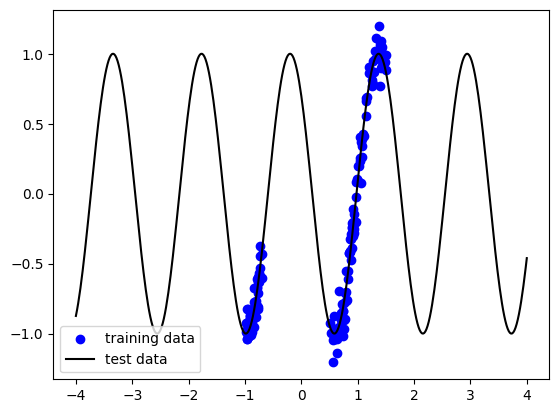

In [6]:
plt.scatter(x.squeeze(), y, color="blue", label='training data')
plt.plot(x_test.squeeze(), y_test, color="black", label='test data')
plt.legend()

# Defining the model

In [10]:
def get_model(output_nodes=1):
    torch.manual_seed(711)
    return nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, output_nodes))
n_epochs = 10000

# VariationalBNN

In [13]:
def bnn(likelihood="homo", scale=None):
    #net_hetero = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 2))
    net_homo = get_model(output_nodes=1 if (likelihood=="homo" and scale is None) else 2)
    prior = tyxe.priors.IIDPrior(dist.Normal(0, 1)) 
    if likelihood=="homo":
        if scale is not None:
            obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=scale)
        else:
            scale = dist.InverseGamma(1,1)
            #scale = pyro.param("scale", torch.Tensor([1.0]),
            #             constraint=constraints.positive)
            obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=scale)
            
    else:
        obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x))
        
    print(obs_model._scale)
    guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
    bnn = tyxe.VariationalBNN(net_homo, prior, obs_model, guide)

    pyro.clear_param_store()
    optim = pyro.optim.Adam({"lr": 1e-3})
    elbos = []
    def callback(bnn, i, e):
        elbos.append(e)

    #with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, n_epochs, callback)
        
    plt.plot(elbos, color="orange")
    plt.show()
    
    sampled_predictions = bnn.predict(x_test, num_predictions=32, aggregate=False)
    return sampled_predictions

def viz_bnn_predictions(sample_predictions):
    print(sample_predictions.shape[-1])
    plt.scatter(x.squeeze(), y, color="blue", label='training data')
    plt.plot(x_test.squeeze(), y_test, color="black", label='test data')
    for yhat in sample_predictions:
        m = yhat[:,0]
        plt.plot(x_test, m, color="green", alpha=1)
        #print(yhat.shape)
        if yhat.shape[-1]==2:
            sd = F.softplus(yhat[:,1])
            plt.plot(x_test, m+sd, color="green", alpha=0.1)
            plt.plot(x_test, m-sd, color="green", alpha=0.1)
    plt.ylim(-2, 2)
    plt.legend()
    plt.show()

In [14]:
pred_homo = bnn(likelihood="homo", scale=None)
#pred_hetero = bnn(likelihood="hetero")

setting scale as a distribution
scale & precision: tensor(1.4836) None
tensor(0.7126)


/media/gala/DataDisk/2022_gala_ddsa/TyXe/venv/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'likelihood._scale'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


KeyError: 'likelihood._scale'

1


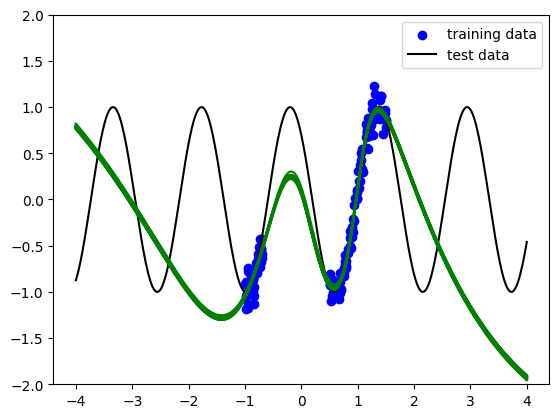

2


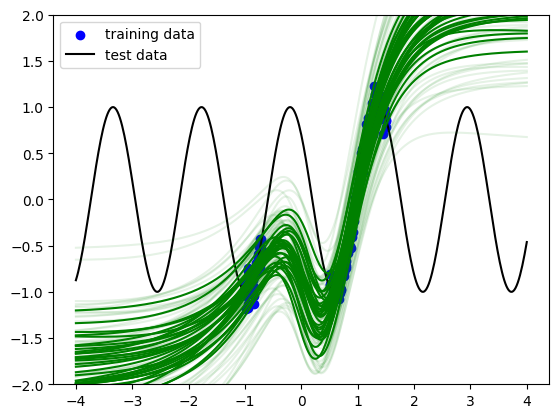

In [69]:
viz_bnn_predictions(pred_homo)
viz_bnn_predictions(pred_hetero)

In [ ]:
#plt.scatter(x, y, color="black")
sampled_predictions = bnn.predict(x_test, num_predictions=25)
print(sampled_predictions[0])
m, sd = torch.swapaxes(sampled_predictions, 0, 1)
print(m[0], sd[0])
print(m[-1], sd[-1])
plt.scatter(x.squeeze(), y, color="blue", label='training data')
plt.plot(x_test.squeeze(), y_test, color="black", label='test data')
plt.plot(x_test, m.detach(), color="green")
for c in [1]:
    plt.fill_between(x_test.squeeze(), (m - c * torch.abs(sd)).squeeze(), (m + c * torch.abs(sd)).squeeze(), alpha=c * 0.1, color="green")
plt.ylim(-2, 2)

In [ ]:
with tyxe.poutine.local_reparameterization():
    m, sd = bnn.predict(x_test, num_predictions=32)

torch.save((x, y, x_test, y_test, m, sd), "ffg_lr_predictions.pt")

In [ ]:
plt.scatter(x.squeeze(), y, color="blue", label='training data')
plt.plot(x_test.squeeze(), y_test, color="black", label='test data')
plt.plot(x_test, m.detach(), color="blue")
for c in [1]:
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="green")
plt.ylim(-2, 2)

# Deterministic model

In [31]:
net = get_model()
optim = torch.optim.Adam(net.parameters(), 1e-4)
n_epochs = 10000
for _ in range(n_epochs):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

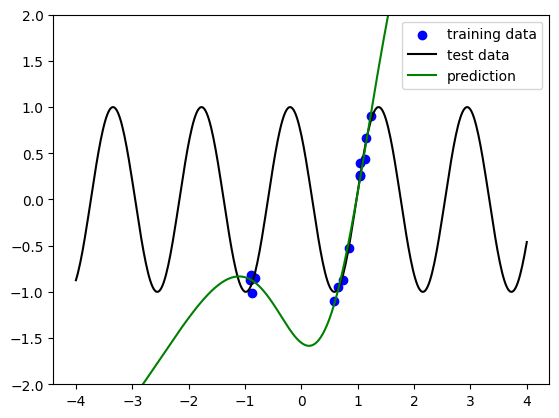

In [32]:
plt.scatter(x.squeeze(), y, color="blue", label='training data')
plt.plot(x_test.squeeze(), y_test, color="black", label='test data')
plt.plot(x_test, net(x_test).detach(), color="green", label='prediction')
plt.ylim(-2, 2)
plt.legend()

# Laplace approximation

In [18]:
la = Laplace(net, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [19]:
f_mu, f_var = la(x_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

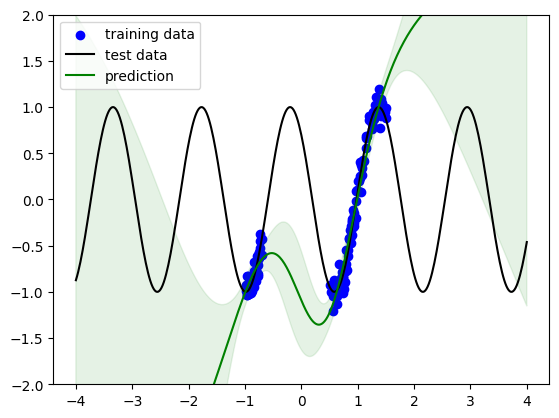

In [20]:
plt.scatter(x.squeeze(), y, color="blue", label='training data')
plt.plot(x_test.squeeze(), y_test, color="black", label='test data')
plt.plot(x_test, f_mu, color="green", label='prediction')
plt.fill_between(x_test.squeeze(), (f_mu - pred_std).squeeze(), (f_mu + pred_std).squeeze(), alpha=0.1, color="green")
plt.ylim(-2, 2)
plt.legend()

# MCMC BNN

In [ ]:
pyro.clear_param_store()
net = get_model()
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=50, target_accept_prob=0.7)
bnn = tyxe.bnn.MCMC_BNN(net, prior, obs_model, kernel)

In [ ]:
bnn.fit(loader, 100000, warmup_steps=20000)

In [ ]:
m, sd = bnn.predict(x_test, num_predictions=32)

In [ ]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

In [ ]:
sampled_predictions = bnn.predict(x_test, num_predictions=25, aggregate=False)
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="blue", alpha=0.3)
plt.ylim(-2, 2)